# Práctica Bloque 2 - IA

Autores: Sergi Mayol Matos, Alejandro Rodríguez Arguimbau <br>
Correos: sergi.mayol1@estudiant.uib.cat, alejandro.rodriguez7@estudiant.uib.cat <br>
Fecha: 06/12/2022

## Prerrequisitos

Para los siguientes apartados ([parte 1](#parte-1-preparación-de-los-datos) y [parte 2]()) se emplearán las siguientes librerías:

* [numpy](https://numpy.org/)
* [pandas](https://pandas.pydata.org/)
* [matplotlib](https://matplotlib.org/)
* [sklearn](https://scikit-learn.org/stable/)

> Nota: Para ver más información sobre las librerías, mirar el fichero [Pipfile](./Pipfile).

### Instalación de librerías

Para instalar las librerías, se debe ejecutar el siguiente comando:

```bash
pipenv install -d
```

> Nota: Se necesita tener instalado [pipenv](https://pypi.org/project/pipenv/).

### Importación de librerías

In [117]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Parte 1: Entrenamiento de modelos y comparación de resultados 

En la primera parte de la práctica se entrenarán diferentes modelos de clasificación (Regrsión lineal, Perceptrón, Random Forest) y se compararán sus resultados.

### Carga de datos

In [118]:
df = pd.read_csv("./datos/dades.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Análisis y procesamiento de datos

En esta sección se analizarán los datos de entrada para ver si hay que eliminar o modificar algún dato.

Para analizar los datos, comprobaremos la cantidad de datos que faltan en cada columna.

In [119]:
def check_is_nan(df: pd.DataFrame):
    results = []
    col_names = []
    for col in df.columns:
        col_names.append(col)
        results.append(df[col].isna().sum())

    return {"col_names": col_names, "results": results, "percent": [x/len(df) for x in results]}


results = check_is_nan(df)

for i in range(len(results["col_names"])):
    print(
        f"{results['col_names'][i]}: {results['results'][i]} ({results['percent'][i]})")

PassengerId: 0 (0.0)
Survived: 0 (0.0)
Pclass: 0 (0.0)
Name: 0 (0.0)
Sex: 0 (0.0)
Age: 177 (0.19865319865319866)
SibSp: 0 (0.0)
Parch: 0 (0.0)
Ticket: 0 (0.0)
Fare: 0 (0.0)
Cabin: 687 (0.7710437710437711)
Embarked: 2 (0.002244668911335578)


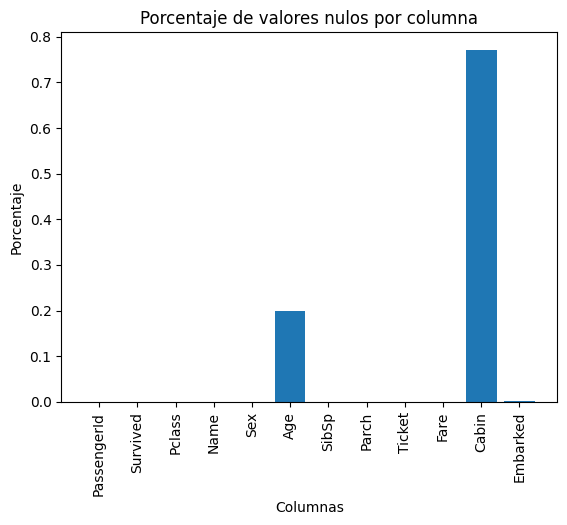

In [120]:
plt.bar(results["col_names"], results["percent"])
plt.title("Porcentaje de valores nulos por columna")
plt.xlabel("Columnas")
plt.ylabel("Porcentaje")
plt.xticks(rotation=90)
plt.show()

Se puede observar que hay 3 columnas con datos faltantes:

* `Age`
* `Cabin`
* `Embarked`

Aunque de las 3 columnas, la columna con más datos faltantes, con diferencia, es `Cabin`, casi un 80%. Por ello, se eliminará esta columna.

Por lo que los datos que quedan, de momento, son:

In [121]:
df.drop(['Cabin'], axis=1, inplace=True)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


Para las columnas `Age` y `Embarked`, se rellenarán los datos faltantes con la media y la moda, respectivamente. Se realizará la media de `Age`, ya que faltan aproximadamente un **20%** de los datos, y la moda de `Embarked`, ya que faltan muy pocos datos y no son datos numéricos.

In [122]:
media_edad = df["Age"].mean()
df["Age"].fillna(media_edad, inplace=True)

moda_embarque = df["Embarked"].mode()[0]
df["Embarked"].fillna(moda_embarque, inplace=True)

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


En este caso las columnas `Name` y `Ticket` no las vamos a utilizar y por eso las eliminamos del conjunto de datos.

In [123]:
#df.drop(['Name'], axis=1, inplace=True)
#df.drop(['Ticket'], axis=1, inplace=True)
#df.head()

Convertimos la columna `Sex` en 0 y 1:
* Hombres: 0
* Mujeres: 1

In [124]:
df['Sex']=df['Sex'].replace('male', 0)
df['Sex']=df['Sex'].replace('female', 1)
#clb = df.pop("Sex")
#ohe_clb = pd.get_dummies(clb, prefix='Sex')
#df = pd.concat([df.reset_index(drop=True), ohe_clb.reset_index(drop=True)], axis=1, sort=False)
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,S


Obtenemos el tamaño de cada familia y la añadimos al conjunto de datos.

In [125]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
# One-hot encoding para la columna Embarked
clb = df.pop("Embarked")
ohe_clb = pd.get_dummies(clb, prefix='Embarked')
df = pd.concat([df.reset_index(drop=True), ohe_clb.reset_index(drop=True)], axis=1, sort=False)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,FamilySize,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,2,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,2,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,1,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,2,0,0,1
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,1,0,0,1


Se puede dividir la columna `Age` en 5 grupos:
* 0-12  $\rightarrow$ Niños
* 13-17 $\rightarrow$ Adolescentes
* 18-45 $\rightarrow$ Adultos
* 46-64 $\rightarrow$ Adultos mayores
* 65+   $\rightarrow$ Ancianos

Además, se puede dividir la columna `Fare` en 4 grupos:
* 0-7.91   $\rightarrow$ Bajo
* 7.91-14.45 $\rightarrow$ Medio
* 14.45-31 $\rightarrow$ Alto
* 31+      $\rightarrow$ Muy alto

In [126]:
# get max value of the column 'Fare'
max_value = df['Fare'].max()
# get max value of the column 'Age'
max_value_age = df['Age'].max()

print(max_value)
print(max_value_age)

for age in df:
    df['Age_type'] = pd.cut(df['Age'], bins=[0, 13, 18, 45, 65, 120], labels=['Child', 'Teenager', 'Adult', 'Senior', 'Elderly'])

for fare in df:
    df['Fare_type'] = pd.cut(df['Fare'], bins=[0, 7.91, 14.454, 31, 120], labels=['Low_fare', 'median_fare', 'Average_fare', 'high_fare'])

df.drop(['Age'], axis=1, inplace=True)
df.drop(['Fare'], axis=1, inplace=True)

df.head()

512.3292
80.0


,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,FamilySize,Embarked_C,Embarked_Q,Embarked_S,Age_type,Fare_type
0,1,0,3,"Braund, Mr. Owen Harris",0,1,0,A/5 21171,2,0,0,1,Adult,Low_fare
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,1,0,PC 17599,2,1,0,0,Adult,high_fare
2,3,1,3,"Heikkinen, Miss. Laina",1,0,0,STON/O2. 3101282,1,0,0,1,Adult,median_fare
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,1,0,113803,2,0,0,1,Adult,high_fare
4,5,0,3,"Allen, Mr. William Henry",0,0,0,373450,1,0,0,1,Adult,median_fare


In [127]:
# One-hot encoding para la columna Age_type 
clb = df.pop("Age_type")
ohe_clb = pd.get_dummies(clb, prefix='Age')
df = pd.concat([df.reset_index(drop=True), ohe_clb.reset_index(drop=True)], axis=1, sort=False)

# One-hot encoding para la columna Fare_type
clb = df.pop("Fare_type")
ohe_clb = pd.get_dummies(clb, prefix='Fare')
df = pd.concat([df.reset_index(drop=True), ohe_clb.reset_index(drop=True)], axis=1, sort=False)

df.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,FamilySize,Embarked_C,...,Embarked_S,Age_Child,Age_Teenager,Age_Adult,Age_Senior,Age_Elderly,Fare_Low_fare,Fare_median_fare,Fare_Average_fare,Fare_high_fare
0,1,0,3,"Braund, Mr. Owen Harris",0,1,0,A/5 21171,2,0,...,1,0,0,1,0,0,1,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,1,0,PC 17599,2,1,...,0,0,0,1,0,0,0,0,0,1
2,3,1,3,"Heikkinen, Miss. Laina",1,0,0,STON/O2. 3101282,1,0,...,1,0,0,1,0,0,0,1,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,1,0,113803,2,0,...,1,0,0,1,0,0,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",0,0,0,373450,1,0,...,1,0,0,1,0,0,0,1,0,0


Se realiza la matriz de correlación

In [128]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')


,PassengerId,Survived,Pclass,Sex,SibSp,Parch,FamilySize,Embarked_C,Embarked_Q,Embarked_S,Age_Child,Age_Teenager,Age_Adult,Age_Senior,Age_Elderly,Fare_Low_fare,Fare_median_fare,Fare_Average_fare,Fare_high_fare
PassengerId,1.000000,-0.005007,-0.035144,-0.042939,-0.057527,-0.001652,-0.040143,-0.001205,-0.033606,0.022204,-0.009668,0.008710,-0.027175,0.039078,0.003516,0.031688,-0.013074,-0.037395,0.013862
Survived,-0.005007,1.000000,-0.338481,0.543351,-0.035322,0.081629,0.016639,0.168240,0.003650,-0.149683,0.125678,0.016506,-0.078405,0.004003,-0.050661,-0.200973,-0.087603,0.074470,0.173164
Pclass,-0.035144,-0.338481,1.000000,-0.131900,0.083081,0.018443,0.065997,-0.243292,0.221009,0.074053,0.114504,0.060768,0.122878,-0.310384,-0.063635,0.450238,0.200349,-0.042044,-0.453875
Sex,-0.042939,0.543351,-0.131900,1.000000,0.114631,0.245489,0.200988,0.082853,0.074115,-0.119224,0.077893,0.088803,-0.067166,-0.026484,-0.070217,-0.168288,-0.079221,0.092995,0.116980
SibSp,-0.057527,-0.035322,0.083081,0.114631,1.000000,0.414838,0.890712,-0.059528,-0.026354,0.068734,0.345454,0.040025,-0.184149,-0.061654,-0.034374,-0.232991,-0.202833,0.121717,0.336510
Parch,-0.001652,0.081629,0.018443,0.245489,0.414838,1.000000,0.783111,-0.011069,-0.081228,0.060814,0.364779,0.031754,-0.205642,-0.041761,-0.030317,-0.244930,-0.203853,0.161366,0.253944
FamilySize,-0.040143,0.016639,0.065997,0.200988,0.890712,0.783111,1.000000,-0.046215,-0.058592,0.077359,0.418344,0.043219,-0.228595,-0.063001,-0.038639,-0.281604,-0.240471,0.163805,0.356859
Embarked_C,-0.001205,0.168240,-0.243292,0.082853,-0.059528,-0.011069,-0.046215,1.000000,-0.148258,-0.782742,-0.014698,0.034349,-0.053997,0.056595,0.014953,-0.035399,-0.199984,0.038225,0.151024
Embarked_Q,-0.033606,0.003650,0.221009,0.074115,-0.026354,-0.081228,-0.058592,-0.148258,1.000000,-0.499421,-0.031503,-0.028231,0.089027,-0.080368,0.013069,0.311829,-0.118679,-0.016363,-0.137169
Embarked_S,0.022204,-0.149683,0.074053,-0.119224,0.068734,0.060814,0.077359,-0.782742,-0.499421,1.000000,0.032701,-0.012325,-0.008721,0.000996,-0.021324,-0.165224,0.249879,-0.023189,-0.045983


Se observa que las columnas `Sex` y `Survived` tienen una correlación de 0.54, por lo que se puede decir que hay una relación entre la supervivencia y el sexo. También, se observa que `Parch` y `SibSp` ...

In [129]:
#df.drop(['SibSp'], axis=1, inplace=True)
#df.drop(['Parch'], axis=1, inplace=True)
df.drop(['PassengerId'], axis=1, inplace=True)
df.drop(['Name'], axis=1, inplace=True)
df.drop(['Ticket'], axis=1, inplace=True)
# Las columnas de embarque no aportan nada a la predicción, por lo que las eliminamos
#df.drop(['Embarked_C'], axis=1, inplace=True)
#df.drop(['Embarked_Q'], axis=1, inplace=True)
#df.drop(['Embarked_S'], axis=1, inplace=True)

corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')


,Survived,Pclass,Sex,SibSp,Parch,FamilySize,Embarked_C,Embarked_Q,Embarked_S,Age_Child,Age_Teenager,Age_Adult,Age_Senior,Age_Elderly,Fare_Low_fare,Fare_median_fare,Fare_Average_fare,Fare_high_fare
Survived,1.000000,-0.338481,0.543351,-0.035322,0.081629,0.016639,0.168240,0.003650,-0.149683,0.125678,0.016506,-0.078405,0.004003,-0.050661,-0.200973,-0.087603,0.074470,0.173164
Pclass,-0.338481,1.000000,-0.131900,0.083081,0.018443,0.065997,-0.243292,0.221009,0.074053,0.114504,0.060768,0.122878,-0.310384,-0.063635,0.450238,0.200349,-0.042044,-0.453875
Sex,0.543351,-0.131900,1.000000,0.114631,0.245489,0.200988,0.082853,0.074115,-0.119224,0.077893,0.088803,-0.067166,-0.026484,-0.070217,-0.168288,-0.079221,0.092995,0.116980
SibSp,-0.035322,0.083081,0.114631,1.000000,0.414838,0.890712,-0.059528,-0.026354,0.068734,0.345454,0.040025,-0.184149,-0.061654,-0.034374,-0.232991,-0.202833,0.121717,0.336510
Parch,0.081629,0.018443,0.245489,0.414838,1.000000,0.783111,-0.011069,-0.081228,0.060814,0.364779,0.031754,-0.205642,-0.041761,-0.030317,-0.244930,-0.203853,0.161366,0.253944
FamilySize,0.016639,0.065997,0.200988,0.890712,0.783111,1.000000,-0.046215,-0.058592,0.077359,0.418344,0.043219,-0.228595,-0.063001,-0.038639,-0.281604,-0.240471,0.163805,0.356859
Embarked_C,0.168240,-0.243292,0.082853,-0.059528,-0.011069,-0.046215,1.000000,-0.148258,-0.782742,-0.014698,0.034349,-0.053997,0.056595,0.014953,-0.035399,-0.199984,0.038225,0.151024
Embarked_Q,0.003650,0.221009,0.074115,-0.026354,-0.081228,-0.058592,-0.148258,1.000000,-0.499421,-0.031503,-0.028231,0.089027,-0.080368,0.013069,0.311829,-0.118679,-0.016363,-0.137169
Embarked_S,-0.149683,0.074053,-0.119224,0.068734,0.060814,0.077359,-0.782742,-0.499421,1.000000,0.032701,-0.012325,-0.008721,0.000996,-0.021324,-0.165224,0.249879,-0.023189,-0.045983
Age_Child,0.125678,0.114504,0.077893,0.345454,0.364779,0.418344,-0.014698,-0.031503,0.032701,1.000000,-0.084582,-0.481878,-0.101655,-0.028008,-0.152587,-0.080063,0.168361,0.085364


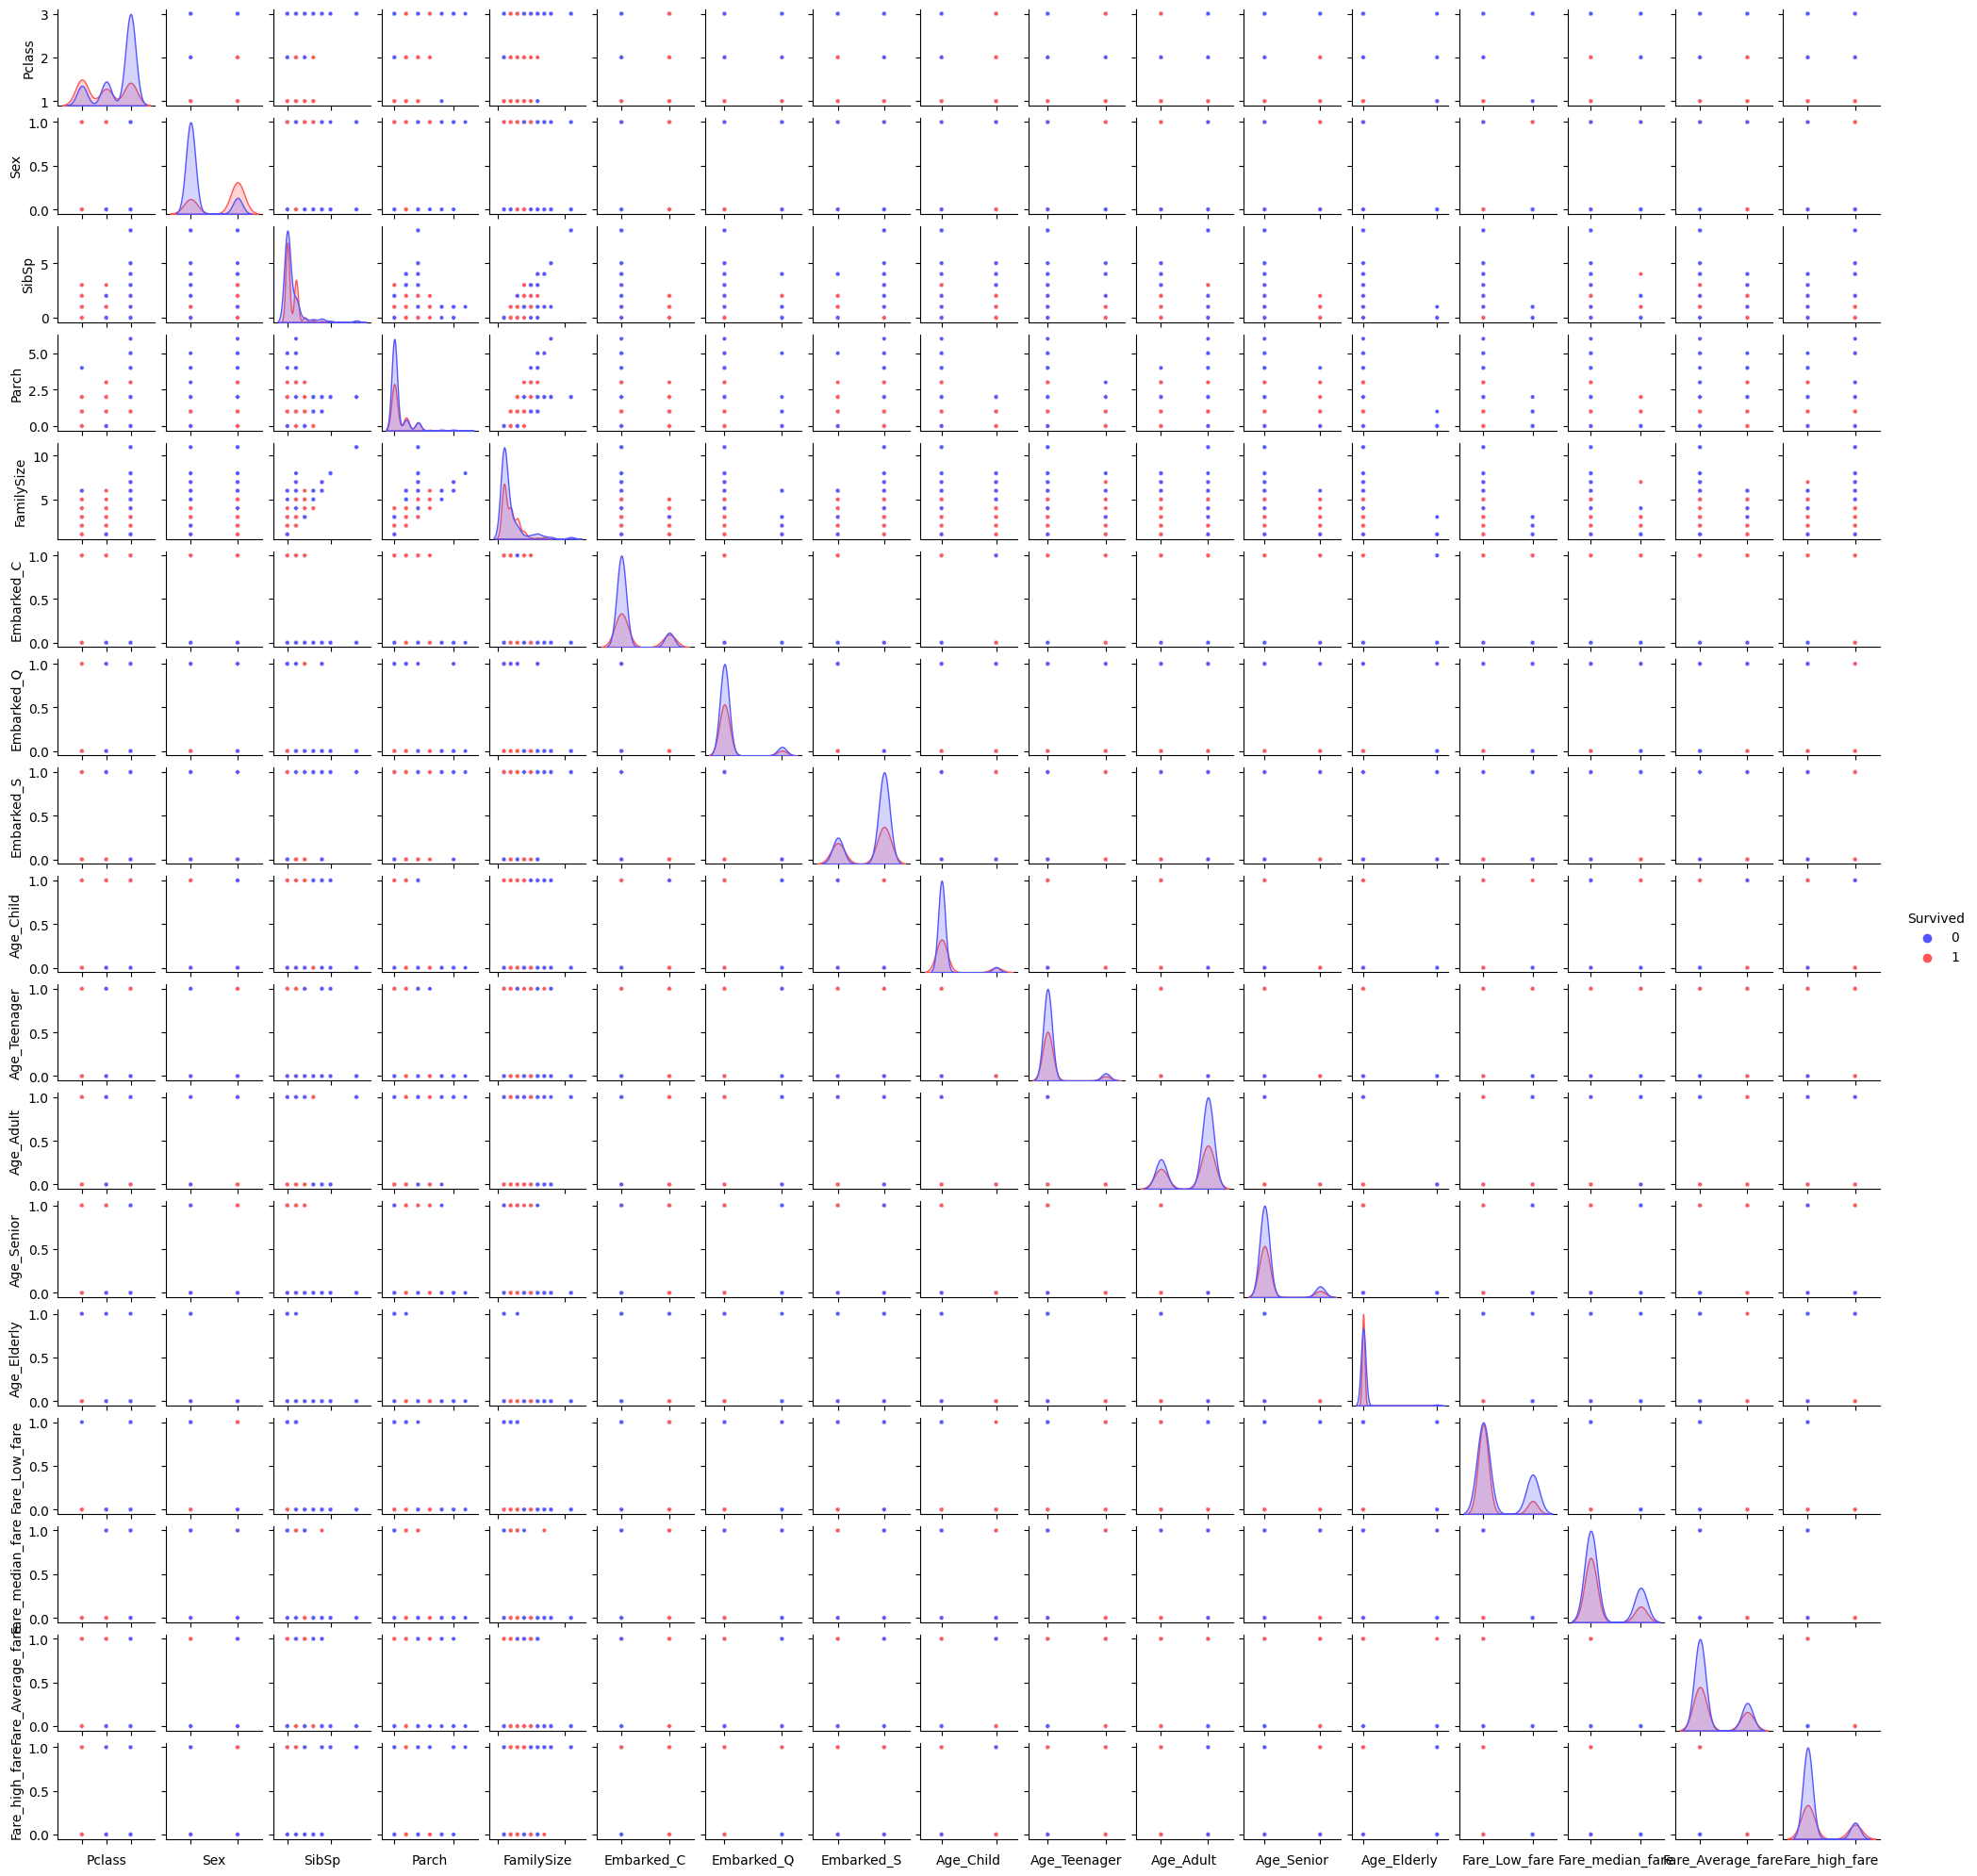

In [130]:
g = sns.pairplot(data=df, hue='Survived', palette = 'seismic',
                 size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

### Entrenamiento de modelos

In [131]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, mean_absolute_error, mean_squared_error,
                             classification_report)

training_ds = df.drop(['Survived'], axis=1)
target_ds = df['Survived']

# Dividimos el dataset en train y test
X_train, X_test, y_train, y_test = train_test_split(
    training_ds, target_ds, test_size=0.33, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((596, 17), (295, 17), (596,), (295,))

#### Regresión logística

Classification report: 
               precision    recall  f1-score   support

           0       0.82      0.86      0.84       175
           1       0.78      0.73      0.76       120

    accuracy                           0.81       295
   macro avg       0.80      0.80      0.80       295
weighted avg       0.81      0.81      0.81       295



<AxesSubplot:>

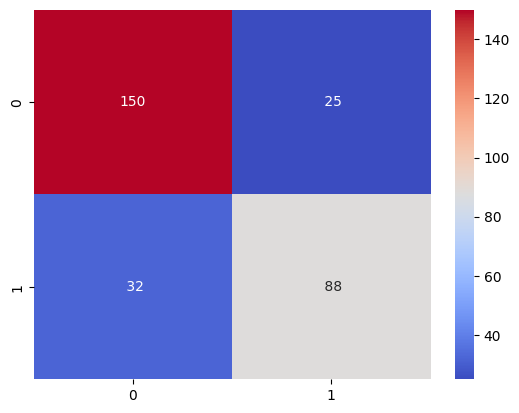

In [136]:
from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression()

logisticRegr.fit(X_train, y_train)

log_y_pred = logisticRegr.predict(X_test)

print("Classification report: \n", classification_report(y_test, log_y_pred))

# Matriz de confusión
sns.heatmap(confusion_matrix(y_test, log_y_pred),
            annot=True, fmt="3.0f", cmap='coolwarm')


#### Perceptrón

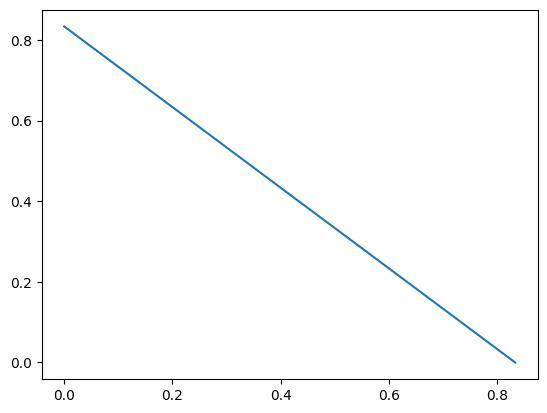

In [133]:
from sklearn.linear_model import Perceptron

perceptron = Perceptron(tol=1e-3, random_state=42)

perceptron.fit(X_train, y_train)

#x_intercept = -perceptron.intercept_[0] / perceptron.coef_[0][0]
x_intercept = (0, -perceptron.intercept_[0] / perceptron.coef_[0][0])
y_intercept = (-perceptron.intercept_[0] / perceptron.coef_[0][0], 0)

plt.plot(x_intercept, y_intercept)

Classification report: 
               precision    recall  f1-score   support

           0       0.76      0.91      0.83       175
           1       0.81      0.57      0.67       120

    accuracy                           0.77       295
   macro avg       0.78      0.74      0.75       295
weighted avg       0.78      0.77      0.76       295



<AxesSubplot:>

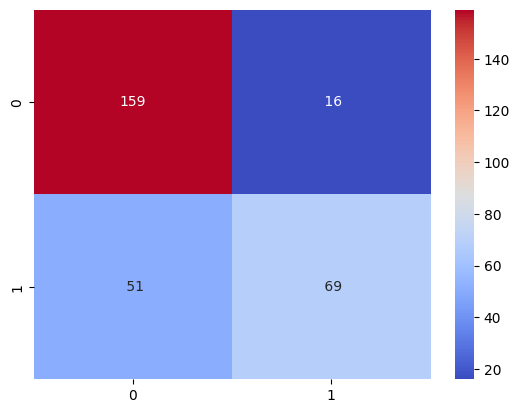

In [137]:
percep_y_pred = perceptron.predict(X_test)

print("Classification report: \n", classification_report(y_test, percep_y_pred))

# Plot the data, the prediction and the dividing line
# plt.scatter(X_test['Sex'], y_test, c=pred, cmap='coolwarm')

# plt.plot(x_intercept, y_intercept)
sns.heatmap(confusion_matrix(y_test, percep_y_pred),
            annot=True, fmt="3.0f", cmap='coolwarm')


#### Árbol de decisión - Random Forest

Primero hay que determinar los mejores párametros para el modelo. Para ello, se empleará la función `GridSearchCV` de la librería `sklearn`.

In [149]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [80, 90, 100, 110],
    'min_samples_leaf': [1, 2, 3, 4],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 500, 700, 1000],
}

# Create a based model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

result = grid_search.best_params_

print(result)


Fitting 3 folds for each of 576 candidates, totalling 1728 fits
{'bootstrap': True, 'max_depth': 110, 'min_samples_leaf': 4, 'min_samples_split': 12, 'n_estimators': 500}


Una vez se han obtenido los mejores parámetros, se entrena el modelo con estos parámetros. Y se obtiene la precisión del modelo.

In [150]:
rf = RandomForestClassifier(bootstrap=result['bootstrap'], max_depth=result['max_depth'],
                            min_samples_leaf=result['min_samples_leaf'], min_samples_split=result['min_samples_split'],
                            n_estimators=result['n_estimators'])

rf.fit(X_train, y_train)

rf_y_pred = rf.predict(X_test)

print("Classification report: \n", classification_report(y_test, rf_y_pred))


Classification report: 
               precision    recall  f1-score   support

           0       0.81      0.87      0.84       175
           1       0.79      0.71      0.75       120

    accuracy                           0.81       295
   macro avg       0.80      0.79      0.80       295
weighted avg       0.81      0.81      0.80       295



Y se obtiene la matriz de confusión.

<AxesSubplot:>

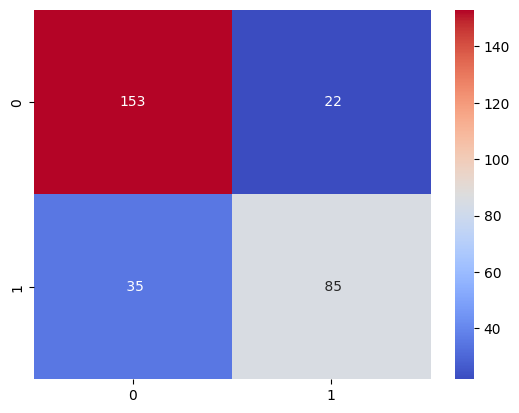

In [151]:
# Matriz de confusión
sns.heatmap(confusion_matrix(y_test, rf_y_pred),
            annot=True, fmt="3.0f", cmap='coolwarm')

### Evaluación y comparción de resultados

In [155]:
modelos = pd.DataFrame({
    'Modelo': ['Regresión Logística', 'Perceptrón', 'Random Forest'],
    'Score': [round(accuracy_score(y_test, log_y_pred), 2), round(accuracy_score(y_test, percep_y_pred), 2), round(accuracy_score(y_test, rf_y_pred), 2)],
    'Precision': [round(precision_score(y_test, log_y_pred), 2), round(precision_score(y_test, percep_y_pred), 2), round(precision_score(y_test, rf_y_pred), 2)],
    'Recall': [round(recall_score(y_test, log_y_pred), 2), round(recall_score(y_test, percep_y_pred), 2), round(recall_score(y_test, rf_y_pred), 2)],
    'F1': [round(f1_score(y_test, log_y_pred), 2), round(f1_score(y_test, percep_y_pred), 2), round(f1_score(y_test, rf_y_pred), 2)],
    'MAE': [round(mean_absolute_error(y_test, log_y_pred), 2), round(mean_absolute_error(y_test, percep_y_pred), 2), round(mean_absolute_error(y_test, rf_y_pred), 2)],
    'MSE': [round(mean_squared_error(y_test, log_y_pred), 2), round(mean_squared_error(y_test, percep_y_pred), 2), round(mean_squared_error(y_test, rf_y_pred), 2)]
})

modelos.sort_values(by='Score', ascending=False)

,Modelo,Score,Precision,Recall,F1,MAE,MSE
0,Regresión Logística,0.81,0.78,0.73,0.76,0.19,0.19
2,Random Forest,0.81,0.79,0.71,0.75,0.19,0.19
1,Perceptrón,0.77,0.81,0.57,0.67,0.23,0.23


## Parte 2: Importancia y selección de características